# Neo4j Graph Data Science Python Client




## Installation

`pip install graphdatascience`


# Demo using RailNetworkGB graph database

You need to create, load, adn start the RailNetworkGB graph database before running the client.

# Using RailNetworkGB Database

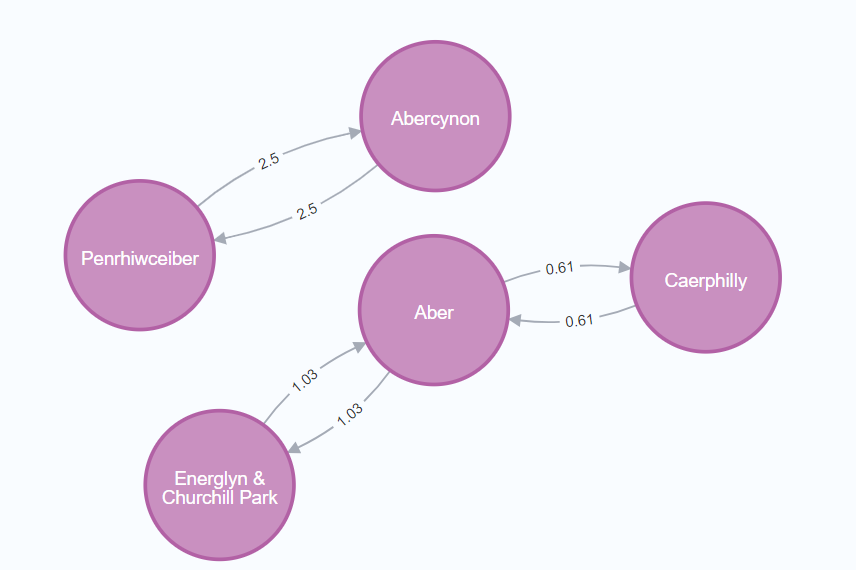

In [1]:
from graphdatascience import GraphDataScience
import os

In [2]:
host = "bolt://localhost:7687"
user = "neo4j"
password = os.environ['Neo4j'] # Require the Database's PW stored on the environment variable Neo4j

gds = GraphDataScience(host, auth=(user, password))

We can verify that the connection is valid and the target Neo4j instance has the GDS library installed by using the gds.version() method.

In [3]:
# Check if connection is valid and the target database has GDS installed
print(gds.version())

2.6.8


# Executing Cypher statements

The Python client allows you to execute arbitrary Cypher statements using the run_cypher method. 
The method takes two parameters are input. The first and mandatory parameter is the Cypher query you want to execute. 
The second method parameter is optional and can be used to provide any query parameters.
 

In [4]:
# df returned is a DataFrame
df = gds.run_cypher("""
MATCH (s:Station)
return s.crs as station, apoc.node.degree(s, "TRACK")/2 as degree
order by degree desc
""")

In [5]:
df

,station,degree
0,GLC,10
1,BHM,9
2,LDS,8
3,DON,8
4,LBG,7
...,...,...
2588,SPX,0
2589,SMC,0
2590,AGR,0
2591,NTB,0


In [6]:
degree = df['degree']
degree.describe()

count    2593.000000
mean        2.229850
std         0.769552
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        10.000000
Name: degree, dtype: float64

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')

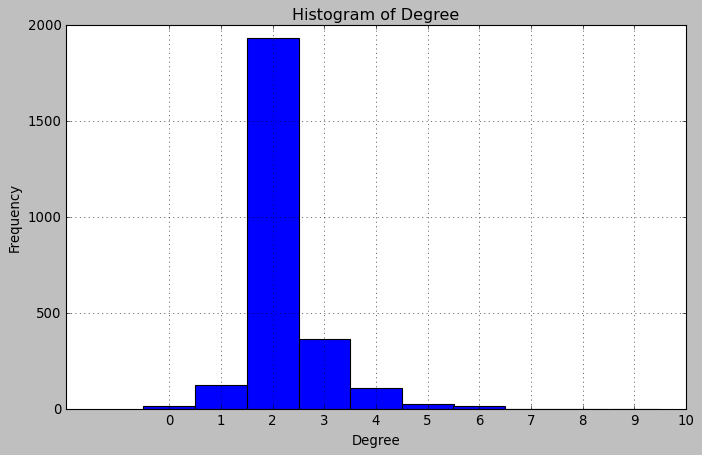

In [11]:
# Create and save the plot
plt.figure(figsize=(10, 6))
plt.hist(degree, bins=range(0, 11), edgecolor='black', align='left')
plt.title('Histogram of Degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.xticks(range(0, 11))
plt.grid(True)

# plt.savefig('histogram_degree_plot.png')


## Create a graph projection

In [12]:
gds.graph.project.cypher(
graph_name='trains',
node_spec='MATCH (s:Station) RETURN id(s) AS id',
relationship_spec=
"""
MATCH (s1:Station)-[t:TRACK]->(s2:Station)
RETURN id(s1) AS source, id(s2) AS target, t.distance AS distance
"""
)

(<graphdatascience.graph.graph_object.Graph at 0x18d2e160d30>,
 nodeQuery                         MATCH (s:Station) RETURN id(s) AS id
 relationshipQuery    MATCH (s1:Station)-[t:TRACK]->(s2:Station)\nRE...
 graphName                                                       trains
 nodeCount                                                         2593
 relationshipCount                                                 5782
 projectMillis                                                       67
 Name: 0, dtype: object)

In [14]:
gds.graph.get("trains")

# Shortest Path

In [38]:
bham = gds.find_node_id(["Station"], {"name": "Birmingham New Street"})
eboro = gds.find_node_id(["Station"], {"name": "Edinburgh"})

shortest_path = gds.shortestPath.dijkstra.stream(
gds.graph.get("trains"),
sourceNode=bham,
targetNode=eboro,
relationshipWeightProperty="distance"
)

In [39]:
print(bham)

1142


In [40]:
print(eboro)

1145


Cypher call:

CALL gds.shortestPath.dijkstra.stream('trains', {
    sourceNode: 1142,
    targetNode: 1145,
    relationshipWeightProperty: 'distance'
})
YIELD index, sourceNode, targetNode, totalCost, nodeIds, costs, path
RETURN
    index,
    gds.util.asNode(sourceNode).name AS sourceNodeName,
    gds.util.asNode(targetNode).name AS targetNodeName,
    totalCost,
    [nodeId IN nodeIds | gds.util.asNode(nodeId).name] AS nodeNames,
    costs,
    nodes(path) as path
ORDER BY index

In [41]:
shortest_path

,index,sourceNode,targetNode,totalCost,nodeIds,costs,path
0,0,1142,1145,295.91,"[1142, 921, 915, 859, 939, 852, 956, 907, 2553...","[0.0, 3.91, 5.16, 7.12, 8.01, 9.39, 12.7000000...","((cost), (cost), (cost), (cost), (cost), (cost..."


In [42]:
shortest_path["nodeIds"].get(0)

[1142,
 921,
 915,
 859,
 939,
 852,
 956,
 907,
 2553,
 2545,
 953,
 872,
 814,
 2556,
 2557,
 1316,
 1432,
 2550,
 2546,
 2548,
 2549,
 2543,
 2198,
 2029,
 2174,
 2056,
 2299,
 2168,
 2268,
 2133,
 1145]

In [43]:
print("Shortest distance: %s" % shortest_path.get('costs').get(0)[-1])

Shortest distance: 295.91


In [44]:
path = shortest_path["nodeIds"].get(0)
crs = []
for nid in path:
    crs.append(gds.util.asNode(nid)['crs'])

In [45]:
crs

['BHM',
 'SGB',
 'SAD',
 'DDP',
 'TIP',
 'CSY',
 'WVH',
 'PKG',
 'STA',
 'CRE',
 'WSF',
 'HTF',
 'ACB',
 'WBQ',
 'WGN',
 'EBA',
 'LEY',
 'PRE',
 'LAN',
 'OXN',
 'PNR',
 'CAR',
 'LOC',
 'CRS',
 'KKN',
 'CUH',
 'WTA',
 'KGE',
 'SLA',
 'HYM',
 'EDB']

### Another shortest path example

In [46]:
s = gds.find_node_id(["Station"], {"name": "Birmingham New Street"})
t = gds.find_node_id(["Station"], {"name": "Sandwell & Dudley"})

shortest_path = gds.shortestPath.dijkstra.stream(
gds.graph.get("trains"),
sourceNode=s,
targetNode=t,
relationshipWeightProperty="distance"
)

In [47]:
shortest_path["nodeIds"].get(0)

[1142, 921, 915]

# Betweenness Centrality

In [48]:
graph = gds.graph.get("trains")
result = gds.betweenness.stream(graph)


In [49]:
result

,nodeId,score
0,0,56408.0
1,1,51350.0
2,2,0.0
3,3,117392.0
4,4,5148.0
...,...,...
2588,2588,10292.0
2589,2589,0.0
2590,2590,0.0
2591,2591,10294.0


In [50]:
highest_score = result.sort_values(by="score", ascending=False)

In [51]:
highest_score

,nodeId,score
934,934,1.967643e+06
2545,2545,1.893816e+06
2553,2553,1.848259e+06
2557,2557,1.847857e+06
890,890,1.813216e+06
...,...,...
2279,2279,0.000000e+00
1383,1383,0.000000e+00
2287,2287,0.000000e+00
2290,2290,0.000000e+00


In [52]:
node = gds.util.asNode(934)

In [53]:
node

<Node element_id='4:304b708e-5540-4aa0-8323-f262271dec24:934' labels=frozenset({'Station'}) properties={'name': 'Tamworth', 'address': 'Tamworth station, Victoria Road, Tamworth, Staffordshire, B79 7JT', 'crs': 'TAM', 'long': -1.687269406, 'lat': 52.63712963}>

In [32]:
node['name']

'Tamworth'